### Basic Autoencoder 
Trained on MNIST dataset to generate new MNIST figures 

**Training Steps**:   
- select model and training data 
- process the data 
- train the model 
- evaluate

In [11]:
import time 
import numpy as np 
import torch 
import torch.nn.functional as F 
#dataset imports 
from torchvision import datasets 
from torchvision import transforms
from torch.utils.data import DataLoader


device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available(): 
    torch.backends.cudnn.deterministic= True 

cuda


In [12]:
#hyperparameters 
random_seed=123 
learning_rate= 0.005 
num_epochs= 5 
batch_size=256 

#model architecture (number of features and the size of latent space)
num_features= 784 #same as the total size of the input, since the input is an image, it will be total number of numbers the image conatains (length x width=28x28)
num_hidden_1 = 32 #dimension of the hidden layer/latent space. What our features are reduced to, and will project back to the dimension of 784

**data_loading**

In [13]:
train_data= datasets.MNIST(root= "data", train=True, transform=transforms.ToTensor(), download=True)    # load train data and transform to [0,1] pytorch tensor. Download the dataset to the root directory
test_data= datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=False)    # load test data and transform

process with data loader

In [14]:
train_loader= DataLoader(dataset=train_data, batch_size=batch_size,shuffle=True)
test_loader= DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:     #loader processes the data into batches: 1 x 28 x28 is each image's dimension(grayscale), and 256 of them in one training sample
    print("Image batch dimensions: ", images.shape)
    print("Label batch dimensions: ", labels.shape)

Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])
Image batch dimensions:  torch

## Model architecture

In [15]:
class Autoencoder(torch.nn.Module):
    def __init__(self, num_features):   #take in the total number of features (size of each image)
        super().__init__()

        #encoder architecture  
        self.linear_1= torch.nn.Linear(num_features,num_hidden_1)   #linear transformation to reduce the dimension from original to latent space
        #self.linear by defaults uses the Xavier weight initialization with bias=0 

        #we can customize the weight initialization to customize the weights such as 
        # self.linear_1.weight.detach().normal_(0.0,0.1)    customize weight initialization to mean 0, stand devi 0.1
        # self.linear_1.bias.detach().zero_()   make bias into all zeros. 
        # Use detach() to not interfere with gradient descent  

        #decoder (project back to original dimension from the latent space)
        self.linear_2= torch.nn.Linear(num_hidden_1, num_features)

    def forward(self, img): #input the image as the input 
        #go through encoder 
        encoded= self.linear_1(img)     #linear transformation 
        encoded= F.leaky_relu(encoded)  #non-linear activation function to finish transforming to the latent sapce

        #decode 
        logits= self.linear_2(encoded)  #project back to original dimension 
        decoded= torch.sigmoid(logits)  #go through a different non-linear transformation to finish projecting 
        return decoded  #return newly generated image 


In [16]:
torch.manual_seed(random_seed)  #deterministic model for reproducibility 
model= Autoencoder(num_features=num_features)   #num_features is our parameter 
model= model.to(device) #use cuda to process the model 

optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)  #use Adam optimizer with our learning rate

### Training the model

In [18]:
start_time= time.time() 
for epoch in range(num_epochs):
    for batch_idx, (features,targets) in enumerate(train_loader):
        features= features.view(-1,28*28).to(device)    
        #reshape the features into 256x784, so we can feed in 256 gray scale images each 28x28 into the model (the model will perform transformation on all of them through matrix multiplication)
        #since we are doing unsupervised learning, we don't care about labels. We compare the output with the input

        #forward inference 
        decoded= model(features)        #dim: 256 x 784 
        cost= F.binary_cross_entropy(decoded,features)  #calculate loss between the output and the original input. 
            # maximum likelihood estimation since we have transformed our images to [0,1] tensors 
        optimizer.zero_grad() 
        cost.backward()     #calculate gradients 

        optimizer.step()    #update model parameters 


        #Logging the process 
        if not batch_idx%50:
            print(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | cost: {cost:.4f}")

    print (f"Time elapsed: {(time.time()-start_time)/60:.2f} min")

print(f"total training time: {(time.time()-start_time)/60:.2f}")

Epoch: 1/5 | Batch: 0/235 | cost: 0.1085
Epoch: 1/5 | Batch: 50/235 | cost: 0.1083
Epoch: 1/5 | Batch: 100/235 | cost: 0.1033
Epoch: 1/5 | Batch: 150/235 | cost: 0.1048
Epoch: 1/5 | Batch: 200/235 | cost: 0.1020
Time elapsed: 0.07 min
Epoch: 2/5 | Batch: 0/235 | cost: 0.1032
Epoch: 2/5 | Batch: 50/235 | cost: 0.1043
Epoch: 2/5 | Batch: 100/235 | cost: 0.0999
Epoch: 2/5 | Batch: 150/235 | cost: 0.1012
Epoch: 2/5 | Batch: 200/235 | cost: 0.0990
Time elapsed: 0.13 min
Epoch: 3/5 | Batch: 0/235 | cost: 0.0974
Epoch: 3/5 | Batch: 50/235 | cost: 0.1008
Epoch: 3/5 | Batch: 100/235 | cost: 0.0969
Epoch: 3/5 | Batch: 150/235 | cost: 0.0965
Epoch: 3/5 | Batch: 200/235 | cost: 0.0958
Time elapsed: 0.20 min
Epoch: 4/5 | Batch: 0/235 | cost: 0.1001
Epoch: 4/5 | Batch: 50/235 | cost: 0.0961
Epoch: 4/5 | Batch: 100/235 | cost: 0.0980
Epoch: 4/5 | Batch: 150/235 | cost: 0.0933
Epoch: 4/5 | Batch: 200/235 | cost: 0.0967
Time elapsed: 0.27 min
Epoch: 5/5 | Batch: 0/235 | cost: 0.0927
Epoch: 5/5 | Batch:

### Evaluating the model through comparing the generated outputs

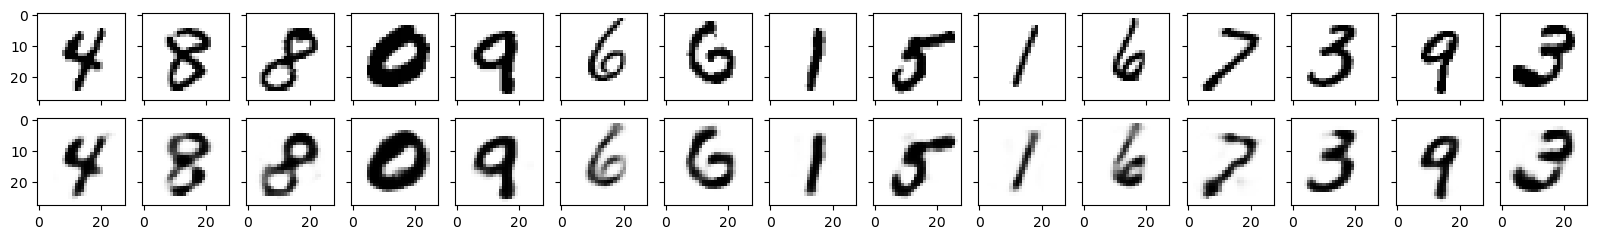

In [20]:
import matplotlib.pyplot as plt 

#visualize the images 

n_images= 15 
img_width= 28 
fig, axes= plt.subplots(nrows=2, ncols=n_images, sharex= True, sharey=True, figsize= (20,2.5))
orig_images= features[:n_images]    #take the first 15 images 
decoded_images= decoded[:n_images]  #take the first 15 generated images 

for i in range(n_images):
    for ax,img in zip(axes, [orig_images, decoded_images]):
        curr_img= img[i].detach().to(torch.device("cpu"))
        ax[i].imshow(curr_img.view(img_width,img_width),cmap="binary")